特徴量抽出を行ったあとの分析結果を示す。以下は掲載コードの概要
1. データ前処理、サンプリング
2. ライブラリのインポート
3. 分類器の定義
4. K層分割検証なしの状態でのROC曲線、AUCを求める
5. 層化K層分割交差検証を行った上でのROC曲線、AUCを求める。
6. チューニング前のaccuracyを求める
7. チューニング後の分類器を再定義
8. チューニング後の分類器に対して、再びROC曲線、AUCを求める。
9. 正解率を求める
10. 8、9でスコア合計が上位3つにはいった分類器を多数決分類器に実装し直し、改めて分類器を再定義。
11. 再定義した分類器と多数決分類器でROC曲線、AUCを求める。
12. 正解率を求める
13. 再現率を求める
14. 多数決分類器のグリッドサーチ


In [1]:
#特徴量を減らした上で、どういう結果が出るか試してみよう
#前処理とサンプリング
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
df=pd.read_csv("train.csv")
df_dummy=pd.get_dummies(df[["job","marital","education",
                            "default","housing","loan",
                            "contact","month","poutcome","subscribed",
                            "age","balance","day","previous",
                            "duration","campaign","pdays"]],drop_first=True)
df_6=pd.DataFrame()
df_6["duration"]=df_dummy["duration"]
df_6["campaign"]=df_dummy["campaign"]
df_6["balance"]=df_dummy["balance"]
df_6["day"]=df_dummy["day"]
df_6["housing_yes"]=df_dummy["housing_yes"]
df_6["age"]=df_dummy["age"]
df_6["subscribed_yes"]=df_dummy["subscribed_yes"]

X,y=df_6.iloc[:,0:6],df_6.iloc[:,6].values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)

from imblearn import FunctionSampler
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

In [2]:
#必要な特徴量の抽出
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve,roc_auc_score,roc_curve,auc
from sklearn.metrics import recall_score, classification_report,confusion_matrix

In [3]:
#分類器の設定
log=LogisticRegression(random_state=1)
dt=DecisionTreeClassifier(random_state=1)
knn=KNeighborsClassifier()
svc=SVC(probability=True)
rfc=RandomForestClassifier(random_state=1)
ada=AdaBoostClassifier(base_estimator=dt,random_state=1)
gb=GradientBoostingClassifier(random_state=1)
all_clf=[log,dt,knn,svc,rfc,ada,gb]
clf_labels=["Logistic Regression","DecisionTree","KNeighbor",
            "SVC","RandomForest","AdaBoost","GradientBoost"]

In [ ]:
#交差検証なし、サンプリングあり、特徴量減らした状態での分析
fig=plt.figure(figsize=(7,5))
colors=["blue","green","red","purple","orange","cyan","olive"]
for clf,label,clr in zip(all_clf,clf_labels,colors):
  y_pred=clf.fit(X_train_res,y_train_res).predict_proba(X_test)[:,1]
  fpr,tpr,thresholds=roc_curve(y_true=y_test,y_score=y_pred)
  roc_auc=auc(x=fpr,y=tpr)
  plt.plot(fpr,tpr,color=clr,label="%s(auc=%0.2f)"%(label,roc_auc))
plt.legend(loc="lower right")
plt.plot([0,0,1],[0,1,1],
         linestyle=":",color="black",label="Perfect Perfomance")
plt.plot([0,1],[0,1],linestyle="--",color="gray",linewidth=2,label="Random Guessing")
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(alpha=0.5)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show
#やはり少し精度が下がってしまう。10～15％程度

In [ ]:
#交差検証を行った状態でのROC曲線とAUCを求める
from sklearn.model_selection import StratifiedKFold
from scipy import interp
all_clf=[log,dt,knn,svc,rfc,ada,gb]
clf_labels=["Logistic Regression","DecisionTree","KNeighbor",
            "SVC","RandomForest","AdaBoost","GradientBoost"]
cv=list(StratifiedKFold(n_splits=5).split(X_train_res,y_train_res))
fig = plt.figure(figsize=(7,5))
#分類器ごとにROC曲線をぷろっと　まずlogistic
mean_fpr_log=np.linspace(0,1,100)
mean_tpr_log= 0.0
for i,(train, test) in enumerate(cv):
  probas = log.fit(X_train_res[train], y_train_res[train]).predict_proba(X_train_res[test])
  fpr_log,tpr_log,thresholds_log=roc_curve(y_train_res[test], probas[:, 1], pos_label=1)
  mean_tpr_log+=interp(mean_fpr_log,fpr_log,tpr_log)
  mean_tpr_log[0]=0
  roc_auc_log=auc(fpr_log, tpr_log)
mean_tpr_log=mean_tpr_log/len(cv)
mean_auc_log=auc(mean_fpr_log, mean_tpr_log)
plt.plot(mean_fpr_log, mean_tpr_log,color="blue",
         label="%s(auc=%0.2f)"%(clf_labels[0],mean_auc_log))
#decisiontree
mean_fpr_dt=np.linspace(0,1,100)
mean_tpr_dt=0.0
for i,(train, test) in enumerate(cv):
  probas=dt.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_dt,tpr_dt,thresholds_dt=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_dt+=interp(mean_fpr_dt,fpr_dt,tpr_dt)
  mean_tpr_dt[0]=0
  roc_auc_dt=auc(fpr_dt,tpr_dt)
mean_tpr_dt=mean_tpr_dt/len(cv)
mean_auc_dt=auc(mean_fpr_dt,mean_tpr_dt)
plt.plot(mean_fpr_dt,mean_tpr_dt,color="green",label="%s(auc=%0.2f)"%(clf_labels[1],mean_auc_dt))
#knn
mean_fpr_knn=np.linspace(0,1,100)
mean_tpr_knn=0.0
for i,(train, test) in enumerate(cv):
  probas=knn.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_knn,tpr_knn,thresholds_knn=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_knn+=interp(mean_fpr_knn,fpr_knn,tpr_knn)
  mean_tpr_knn[0]=0
  roc_auc_knn=auc(fpr_knn, tpr_knn)
mean_tpr_knn=mean_tpr_knn/len(cv)
mean_auc_knn=auc(mean_fpr_knn,mean_tpr_knn)
plt.plot(mean_fpr_knn,mean_tpr_knn,color="red",
         label="%s(auc=%0.2f)"%(clf_labels[2],mean_auc_knn))
#SVC
mean_fpr_svc=np.linspace(0,1,100)
mean_tpr_svc=0.0
for i,(train, test) in enumerate(cv):
  probas=svc.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_svc,tpr_svc,thresholds_svc=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_svc+=interp(mean_fpr_svc,fpr_svc,tpr_svc)
  mean_tpr_svc[0]=0
  roc_auc_svc=auc(fpr_svc,tpr_svc)
mean_tpr_svc=mean_tpr_svc/len(cv)
mean_auc_svc=auc(mean_fpr_svc,mean_tpr_svc)
plt.plot(mean_fpr_svc,mean_tpr_svc,color="purple",
         label="%s(auc=%0.2f)"%(clf_labels[3],mean_auc_svc))
#randomforest
mean_fpr_rfc=np.linspace(0,1,100)
mean_tpr_rfc=0.0
for i,(train, test) in enumerate(cv):
  probas=rfc.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_rfc,tpr_rfc,thresholds_rfc=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_rfc+=interp(mean_fpr_rfc,fpr_rfc,tpr_rfc)
  mean_tpr_rfc[0]=0
  roc_auc_rfc=auc(fpr_rfc,tpr_rfc)
mean_tpr_rfc=mean_tpr_rfc/len(cv)
mean_auc_rfc=auc(mean_fpr_rfc,mean_tpr_rfc)
plt.plot(mean_fpr_rfc,mean_tpr_rfc,color="orange",
         label="%s(auc=%0.2f)"%(clf_labels[4],mean_auc_rfc))
#adaboost
mean_fpr_ada=np.linspace(0,1,100)
mean_tpr_ada=0.0
for i,(train,test) in enumerate(cv):
  probas=ada.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_ada,tpr_ada,thresholds_ada=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_ada+=interp(mean_fpr_ada,fpr_ada,tpr_ada)
  mean_tpr_ada[0]=0
  roc_auc_ada=auc(fpr_ada,tpr_ada)
mean_tpr_ada=mean_tpr_ada/len(cv)
mean_auc_ada=auc(mean_fpr_ada,mean_tpr_ada)
plt.plot(mean_fpr_ada,mean_tpr_ada,color="cyan",
         label="%s(auc=%0.2f)"%(clf_labels[5],mean_auc_ada))
#gradientboost
mean_fpr_gb=np.linspace(0,1,100)
mean_tpr_gb=0.0
for i,(train, test) in enumerate(cv):
  probas=gb.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_gb,tpr_gb,thresholds_gb=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_gb+=interp(mean_fpr_gb,fpr_gb,tpr_gb)
  mean_tpr_gb[0]=0
  roc_auc_gb=auc(fpr_gb,tpr_gb)
mean_tpr_gb=mean_tpr_gb/len(cv)
mean_auc_gb=auc(mean_fpr_gb,mean_tpr_gb)
plt.plot(mean_fpr_gb,mean_tpr_gb,color="olive",
         label="%s(auc=%0.2f)"%(clf_labels[6],mean_auc_gb))
# 当て推量をプロット
plt.plot([0, 1], [0, 1],linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')
plt.plot([0, 0, 1], [0, 1, 1], lw=2, linestyle=':', color='black', label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()

In [ ]:
#accuracyはどうなんかしらね。（チューニング前）
for clf,label in zip(all_clf,clf_labels):
  scores=cross_val_score(estimator=clf,
                         X=X_train_res,
                         y=y_train_res,cv=5,
                         scoring="accuracy")
  print("accuracy: %0.2f(+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))
#正解率は5～15％下がってしまっている。
#まだ改善の余地あり

accuracy: 0.77(+/- 0.00) [LogisticRegression]
accuracy: 0.87(+/- 0.03) [DecisionTree]
accuracy: 0.88(+/- 0.00) [KNeighbor]
accuracy: 0.79(+/- 0.00) [SVC]
accuracy: 0.92(+/- 0.02) [RandomForest]


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


accuracy: 0.87(+/- 0.03) [AdaBoost]
accuracy: 0.86(+/- 0.03) [GradientBoost]


In [3]:
#tuning後のROC曲線をプロットする。まずはtuning後の分類器の設定から
log_best=LogisticRegression(random_state=1,
                            C=0.001,solver="liblinear",
                            penalty="l2")
dt_best=DecisionTreeClassifier(random_state=1,
                               criterion="entropy",
                               max_depth=None,
                               max_features="auto")                              
knn_best=KNeighborsClassifier(n_neighbors=2,
                              weights="uniform")
svc_best=SVC(probability=True,
             kernel="rbf",
             C=100)
rfc_best=RandomForestClassifier(random_state=1,
                                criterion="entropy",
                                max_depth=None,
                                max_features="auto",
                                n_estimators=200)
ada_best=AdaBoostClassifier(base_estimator=dt_best,
                            random_state=1,
                            learning_rate=0.01,
                            n_estimators=50)
gb_best=GradientBoostingClassifier(random_state=1,
                                   max_depth=9,
                                   learning_rate=0.1,
                                   n_estimators=500)
clf_best=[log_best,dt_best,knn_best,svc_best,rfc_best,ada_best,gb_best]
clf_labels=["LogisticRegression","DecisionTree","KNeighbor",
            "SVC","RandomForest","AdaBoost","GradientBoost"]

In [ ]:
#分類器を再定義したうえでのROC曲線、AUCのプロット
from sklearn.model_selection import StratifiedKFold
from scipy import interp
clf_labels=["Logistic Regression","DecisionTree","KNeighbor",
            "SVC","RandomForest","AdaBoost","GradientBoost"]
cv=list(StratifiedKFold(n_splits=5).split(X_train_res,y_train_res))
fig = plt.figure(figsize=(7,5))
#分類器ごとにROC曲線をぷろっと　まずlogistic
mean_fpr_log=np.linspace(0,1,100)
mean_tpr_log= 0.0
for i,(train, test) in enumerate(cv):
  probas = log_best.fit(X_train_res[train], y_train_res[train]).predict_proba(X_train_res[test])
  fpr_log,tpr_log,thresholds_log=roc_curve(y_train_res[test], probas[:, 1], pos_label=1)
  mean_tpr_log+=interp(mean_fpr_log,fpr_log,tpr_log)
  mean_tpr_log[0]=0
  roc_auc_log=auc(fpr_log, tpr_log)
mean_tpr_log=mean_tpr_log/len(cv)
mean_auc_log=auc(mean_fpr_log, mean_tpr_log)
plt.plot(mean_fpr_log, mean_tpr_log,color="blue",
         label="%s(auc=%0.2f)"%(clf_labels[0],mean_auc_log))
#decisiontree
mean_fpr_dt=np.linspace(0,1,100)
mean_tpr_dt=0.0
for i,(train, test) in enumerate(cv):
  probas=dt_best.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_dt,tpr_dt,thresholds_dt=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_dt+=interp(mean_fpr_dt,fpr_dt,tpr_dt)
  mean_tpr_dt[0]=0
  roc_auc_dt=auc(fpr_dt,tpr_dt)
mean_tpr_dt=mean_tpr_dt/len(cv)
mean_auc_dt=auc(mean_fpr_dt,mean_tpr_dt)
plt.plot(mean_fpr_dt,mean_tpr_dt,color="green",label="%s(auc=%0.2f)"%(clf_labels[1],mean_auc_dt))
#knn
mean_fpr_knn=np.linspace(0,1,100)
mean_tpr_knn=0.0
for i,(train, test) in enumerate(cv):
  probas=knn_best.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_knn,tpr_knn,thresholds_knn=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_knn+=interp(mean_fpr_knn,fpr_knn,tpr_knn)
  mean_tpr_knn[0]=0
  roc_auc_knn=auc(fpr_knn, tpr_knn)
mean_tpr_knn=mean_tpr_knn/len(cv)
mean_auc_knn=auc(mean_fpr_knn,mean_tpr_knn)
plt.plot(mean_fpr_knn,mean_tpr_knn,color="red",
         label="%s(auc=%0.2f)"%(clf_labels[2],mean_auc_knn))
#SVC
mean_fpr_svc=np.linspace(0,1,100)
mean_tpr_svc=0.0
for i,(train, test) in enumerate(cv):
  probas=svc_best.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_svc,tpr_svc,thresholds_svc=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_svc+=interp(mean_fpr_svc,fpr_svc,tpr_svc)
  mean_tpr_svc[0]=0
  roc_auc_svc=auc(fpr_svc,tpr_svc)
mean_tpr_svc=mean_tpr_svc/len(cv)
mean_auc_svc=auc(mean_fpr_svc,mean_tpr_svc)
plt.plot(mean_fpr_svc,mean_tpr_svc,color="purple",
         label="%s(auc=%0.2f)"%(clf_labels[3],mean_auc_svc))
#randomforest
mean_fpr_rfc=np.linspace(0,1,100)
mean_tpr_rfc=0.0
for i,(train, test) in enumerate(cv):
  probas=rfc_best.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_rfc,tpr_rfc,thresholds_rfc=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_rfc+=interp(mean_fpr_rfc,fpr_rfc,tpr_rfc)
  mean_tpr_rfc[0]=0
  roc_auc_rfc=auc(fpr_rfc,tpr_rfc)
mean_tpr_rfc=mean_tpr_rfc/len(cv)
mean_auc_rfc=auc(mean_fpr_rfc,mean_tpr_rfc)
plt.plot(mean_fpr_rfc,mean_tpr_rfc,color="orange",
         label="%s(auc=%0.2f)"%(clf_labels[4],mean_auc_rfc))
#adaboost
mean_fpr_ada=np.linspace(0,1,100)
mean_tpr_ada=0.0
for i,(train,test) in enumerate(cv):
  probas=ada_best.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_ada,tpr_ada,thresholds_ada=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_ada+=interp(mean_fpr_ada,fpr_ada,tpr_ada)
  mean_tpr_ada[0]=0
  roc_auc_ada=auc(fpr_ada,tpr_ada)
mean_tpr_ada=mean_tpr_ada/len(cv)
mean_auc_ada=auc(mean_fpr_ada,mean_tpr_ada)
plt.plot(mean_fpr_ada,mean_tpr_ada,color="cyan",
         label="%s(auc=%0.2f)"%(clf_labels[5],mean_auc_ada))
#gradientboost
mean_fpr_gb=np.linspace(0,1,100)
mean_tpr_gb=0.0
for i,(train, test) in enumerate(cv):
  probas=gb_best.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_gb,tpr_gb,thresholds_gb=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_gb+=interp(mean_fpr_gb,fpr_gb,tpr_gb)
  mean_tpr_gb[0]=0
  roc_auc_gb=auc(fpr_gb,tpr_gb)
mean_tpr_gb=mean_tpr_gb/len(cv)
mean_auc_gb=auc(mean_fpr_gb,mean_tpr_gb)
plt.plot(mean_fpr_gb,mean_tpr_gb,color="olive",
         label="%s(auc=%0.2f)"%(clf_labels[6],mean_auc_gb))
# 当て推量をプロット
plt.plot([0, 1], [0, 1],linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')
plt.plot([0, 0, 1], [0, 1, 1], lw=2, linestyle=':', color='black', label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()

In [ ]:
#accuracy の平均を見てみる（チューニング後の結果）
for clf,label in zip(clf_best,clf_labels):
  scores=cross_val_score(estimator=clf,
                         X=X_train_res,
                         y=y_train_res,cv=5,
                         scoring="accuracy")
  print("accuracy: %0.2f(+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))
#logisticなどでは改善はあまり見られなかったが、KNeighborやアンサンブル分類器ではかなりの改善が見られた。

In [6]:
#分類器の定義。チューニングでベストスコアだったKNeighbor,RandomForest,GradientBoostを選んでいる。
knn_best=KNeighborsClassifier(n_neighbors=4,
                              weights="distance")
rfc_best=RandomForestClassifier(random_state=1,
                                criterion="entropy",
                                max_depth=None,
                                max_features="auto",
                                n_estimators=200)
gb_best=GradientBoostingClassifier(random_state=1,
                                   max_depth=9,
                                   learning_rate=0.1,
                                   n_estimators=500)
estimator = [('knn',knn_best),
             ('rfc',rfc_best),
             ('gb', gb_best)]
vt=VotingClassifier(estimators=estimator, voting='soft')
clf_best=[knn_best,rfc_best,gb_best,vt]
clf_labels=["KNeighbor","RandomForest","GradientBoost","MajorityVoting"]

<ipython-input-4-bfd2671692c9>:14: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr_knn+=interp(mean_fpr_knn,fpr_knn,tpr_knn)
<ipython-input-4-bfd2671692c9>:14: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr_knn+=interp(mean_fpr_knn,fpr_knn,tpr_knn)
<ipython-input-4-bfd2671692c9>:14: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr_knn+=interp(mean_fpr_knn,fpr_knn,tpr_knn)
<ipython-input-4-bfd2671692c9>:14: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr_knn+=interp(mean_fpr_knn,fpr_knn,tpr_knn)
<ipython-input-4-bfd2671692c9>:14: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr_knn+=interp(mean_fpr_knn,fpr_knn,tpr_knn)
/usr/local/lib/pytho

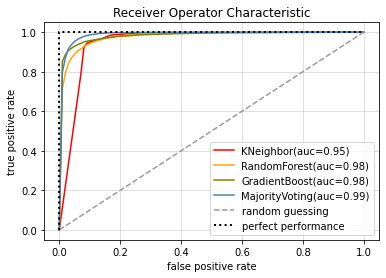

In [4]:
#majorityvoting,randomforest,knn,gradientboostのROC曲線をプロットしてみよう
#
from sklearn.model_selection import StratifiedKFold
from scipy import interp
clf_labels=["KNeighbor","RandomForest","GradientBoost","MajorityVoting"]
cv=list(StratifiedKFold(n_splits=5).split(X_train_res,y_train_res))
fig = plt.figure(figsize=(6,4))
#knn
mean_fpr_knn=np.linspace(0,1,100)
mean_tpr_knn=0.0
for i,(train, test) in enumerate(cv):
  probas=knn_best.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_knn,tpr_knn,thresholds_knn=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_knn+=interp(mean_fpr_knn,fpr_knn,tpr_knn)
  mean_tpr_knn[0]=0
  roc_auc_knn=auc(fpr_knn, tpr_knn)
mean_tpr_knn=mean_tpr_knn/len(cv)
mean_auc_knn=auc(mean_fpr_knn,mean_tpr_knn)
plt.plot(mean_fpr_knn,mean_tpr_knn,color="red",
         label="%s(auc=%0.2f)"%(clf_labels[0],mean_auc_knn))
#randomforest
mean_fpr_rfc=np.linspace(0,1,100)
mean_tpr_rfc=0.0
for i,(train, test) in enumerate(cv):
  probas=rfc_best.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_rfc,tpr_rfc,thresholds_rfc=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_rfc+=interp(mean_fpr_rfc,fpr_rfc,tpr_rfc)
  mean_tpr_rfc[0]=0
  roc_auc_rfc=auc(fpr_rfc,tpr_rfc)
mean_tpr_rfc=mean_tpr_rfc/len(cv)
mean_auc_rfc=auc(mean_fpr_rfc,mean_tpr_rfc)
plt.plot(mean_fpr_rfc,mean_tpr_rfc,color="orange",
         label="%s(auc=%0.2f)"%(clf_labels[1],mean_auc_rfc))
#gradientboost
mean_fpr_gb=np.linspace(0,1,100)
mean_tpr_gb=0.0
for i,(train, test) in enumerate(cv):
  probas=gb_best.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_gb,tpr_gb,thresholds_gb=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_gb+=interp(mean_fpr_gb,fpr_gb,tpr_gb)
  mean_tpr_gb[0]=0
  roc_auc_gb=auc(fpr_gb,tpr_gb)
mean_tpr_gb=mean_tpr_gb/len(cv)
mean_auc_gb=auc(mean_fpr_gb,mean_tpr_gb)
plt.plot(mean_fpr_gb,mean_tpr_gb,color="olive",
         label="%s(auc=%0.2f)"%(clf_labels[2],mean_auc_gb))
#majorityvoting
mean_fpr_vt=np.linspace(0,1,100)
mean_tpr_vt=0.0
for i,(train, test) in enumerate(cv):
  probas=vt.fit(X_train_res[train],y_train_res[train]).predict_proba(X_train_res[test])
  fpr_vt,tpr_vt,thresholds_vt=roc_curve(y_train_res[test],probas[:,1],pos_label=1)
  mean_tpr_vt+=interp(mean_fpr_vt,fpr_vt,tpr_vt)
  mean_tpr_vt[0]=0
  roc_auc_vt=auc(fpr_vt,tpr_vt)
mean_tpr_vt=mean_tpr_vt/len(cv)
mean_auc_vt=auc(mean_fpr_vt,mean_tpr_vt)
plt.plot(mean_fpr_vt,mean_tpr_vt,color="steelblue",
         label="%s(auc=%0.2f)"%(clf_labels[3],mean_auc_vt))
# 当て推量をプロット
plt.plot([0, 1], [0, 1],linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')
plt.plot([0, 0, 1], [0, 1, 1], lw=2, linestyle=':', color='black', label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()

In [ ]:
#accuracyスコア
for clf,label in zip(clf_best,clf_labels):
  scores=cross_val_score(estimator=clf,
                         X=X_train_res,
                         y=y_train_res,cv=5,
                         scoring="accuracy")
  print("accuracy: %0.2f(+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))

In [7]:
#recallスコア
for clf,label in zip(clf_best,clf_labels):
  scores=cross_val_score(estimator=clf,
                         X=X_train_res,
                         y=y_train_res,cv=5,
                         scoring="recall")
  print("recall: %0.2f(+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))

recall: 0.99(+/- 0.00) [KNeighbor]


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

recall: 0.94(+/- 0.05) [RandomForest]
recall: 0.89(+/- 0.22) [GradientBoost]


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

recall: 0.97(+/- 0.06) [MajorityVoting]


In [ ]:
#majorityvotingのグリッドサーチ
#これは諦めました。アルゴリズムの実行にかかる時間が長すぎたので。
estimator = [('knn',KNeighborsClassifier()),
             ('rfc',RandomForestClassifier(random_state=1)),
             ('gb', GradientBoostingClassifier(random_state=1))]
vt_cv=VotingClassifier(estimators=estimator,voting='soft')

vt_params={"knn__n_neighbors":[1,3,5,9],
        "knn__weights":["uniform","distance"],
        "rfc__n_estimators":[200,500],
        'rfc__max_features':['auto', 'sqrt', 'log2'],
        'rfc__max_depth':[5,9,None],
        'rfc__criterion':["gini","entropy","log_loss"],
        "gb__n_estimators":[200,500],
        "gb__learning_rate":[0.01,0.1,1],
        "gb__max_depth":[5,9,None]}

grid=GridSearchCV(estimator=vt_cv,param_grid=vt_params,cv=5,scoring="accuracy",n_jobs=-1)
grid.fit(X_train_res,y_train_res)
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("accuracy :",grid.best_score_)